# Cheat Sheet

In [1]:
import numpy as np
import pandas as pd

from pystatplottools.pdf_env.loading_figure_mode import loading_figure_mode
fma, plt = loading_figure_mode(develop=True) # develop=False will export the generated figures as pngs into "./data/RectangleData"
plt.style.use('seaborn-dark-palette')

## pystatplottools.pytorch_data_generation - In Memory Dataset for a Custom Dataset

### Custom Data Generator

We start by defining a data generator for rectangles with a random unique color.

In [2]:
from pystatplottools.pytorch_data_generation.data_generation.datageneratorbaseclass import DataGeneratorBaseClass


class RectangleGenerator(DataGeneratorBaseClass):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.inp_size = kwargs.pop("dim")
        self.tar_size = 2

        self.h, self.w = self.inp_size
        self.rectangle_hs = np.arange(1, self.h)
        self.rectangle_ws = np.arange(1, self.w)

    def sampler(self):
        rect_h = np.random.choice(self.rectangle_hs)
        rect_w = np.random.choice(self.rectangle_ws)
        sample = np.zeros((self.h, self.w))

        left_idx_h = np.random.randint(0, self.h - rect_h + 1, 1)[0]
        left_idx_w = np.random.randint(0, self.w - rect_w + 1, 1)[0]

        sample[left_idx_h:left_idx_h + rect_h, left_idx_w:left_idx_w + rect_w] = np.random.rand() * (rect_h / (left_idx_w + 1)) / self.h
        return sample, np.array([rect_h, rect_w])


class BatchRectangleGenerator(RectangleGenerator):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.batch_size = kwargs.pop("batch_size")

    def sampler(self):
        rect_hs = np.random.choice(self.rectangle_hs, self.batch_size)
        rect_ws = np.random.choice(self.rectangle_ws, self.batch_size)
        batch = np.zeros((self.batch_size, self.h, self.w))

        left_idx_hs, left_idx_ws = np.zeros(self.batch_size, dtype=np.int), np.zeros(self.batch_size, dtype=np.int)
        for rect_h in self.rectangle_hs:
            left_idx_hs[rect_hs == rect_h] = np.random.randint(0, self.h - rect_h + 1, np.sum(rect_hs == rect_h))
        for rect_w in self.rectangle_ws:
            left_idx_ws[rect_ws == rect_w] = np.random.randint(0, self.w - rect_w + 1, np.sum(rect_ws == rect_w))

        for idx, (sample, rect_h, rect_w, left_idx_h, left_idx_w) in enumerate(zip(batch, rect_hs, rect_ws, left_idx_hs, left_idx_ws)):
            batch[idx, left_idx_h:left_idx_h + rect_h, left_idx_w:left_idx_w + rect_w] = np.random.rand() * (rect_h / (left_idx_w + 1)) / self.h

        return batch, np.stack([rect_hs, rect_ws], axis=1)


def data_generator_factory(data_generator_name="RectangleGenerator"):
    if data_generator_name == "BatchRectangleGenerator":
        return BatchRectangleGenerator
    else:
        return RectangleGenerator

### Preparing and Loading an In-Memory Dataset

The following two functions prepare and load the a generated dataset for the rectangle generator.

In [3]:
def prepare_rectangle_data_in_memory_dataset():
    rel_gen_data_path = "./data/RectangleData"

    ''' Data generation with storage of a permament file '''

    data_generator_args = {
        # RectangleGenerator Args
        "dim": [10, 12]
    }
    # Prepare in memory dataset
    from pystatplottools.pytorch_data_generation.data_generation.datagenerationroutines import \
        prepare_in_memory_dataset
    from examples.rectangle_data_generator import data_generator_factory

    # Write a config.json file providing all necessary information for generating the
    # dataset
    prepare_in_memory_dataset(
        root=rel_gen_data_path,
        batch_size=120,
        n=50000,
        data_generator_args=data_generator_args,
        data_generator_name="BatchRectangleGenerator",
        data_generator_factory=data_generator_factory
    )


def load_rectangle_data_memory_dataset():
    # Load the in memory dataset
    from pystatplottools.pytorch_data_generation.data_generation.datagenerationroutines import \
        load_in_memory_dataset
    from examples.rectangle_data_generator import data_generator_factory
    # When this function is called the first time, the dataset is generated, otherwise, only loaded
    dataset = load_in_memory_dataset(
        root="./data/RectangleData", data_generator_factory=data_generator_factory,
        rebuild=False,
        sample_data_generator_name=None,  # "RectangleGenerator"  # optional: for a generation of new samples
    )
    return dataset

In [4]:
directory = "./results/RectangleData"
prepare_rectangle_data_in_memory_dataset()
dataset = load_rectangle_data_memory_dataset()

from pystatplottools.pytorch_data_generation.data_generation.datagenerationroutines import \
    load_in_memory_data_loader
data_loader = load_in_memory_data_loader(
    dataset=dataset, batch_size=120, slices=(0, 40000), shuffle=True, num_workers=10
)

# Iterate over dataset
for batch_idx, batch in enumerate(data_loader):
    data, target = batch

Random seed is set by np.random.seed()


## pystatplottools.visualization - Inspection of the dataset

In [5]:
from pystatplottools.visualization import sample_visualization

config_dim = (10, 12) # Dimension of the generated samples

# Random sample
config, label = dataset.get_random_sample()
# Random batch with size 108
batch, batch_label = dataset.get_random_batch(108)

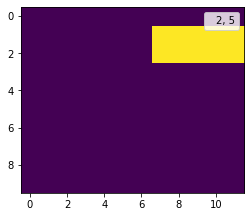

In [6]:
# Single Sample
sample_visualization.fd_im_single_sample(sample=config, label=label, config_dim=config_dim, minmax=(0, 1),
                                         fma=fma, filename="single_sample", directory=directory, figsize=(4, 4));

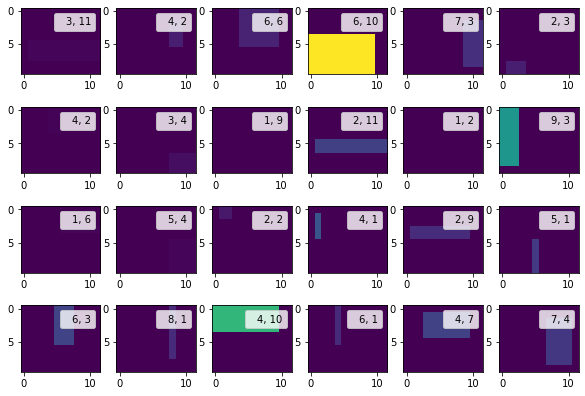

In [7]:
# Batch with labels
sample_visualization.fd_im_batch(batch, batch_labels=batch_label, num_samples=24, dim=(4, 6), config_dim=config_dim,
                                 ab=(batch[:24].cpu().numpy().min(), batch[:24].cpu().numpy().max()), fma=fma, filename="batch", directory=directory, width=3.0);

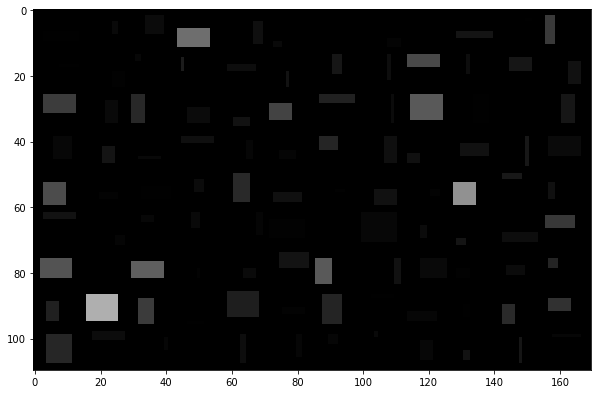

In [8]:
# Batch grid
sample_visualization.fd_im_batch_grid(batch, config_dim=config_dim, ab=(0, 1),
                                      fma=fma, filename="batch_grid", directory=directory);

## pystatplottools.expectation_values - Expectation Values of the Rectangle Dataset

In [9]:
from examples.mock_data import load_characteristics
data = load_characteristics()
data

height  width      mean     color  dx  dy
A                                                
1  0         1      1  0.000077  0.009188   7   2
   1         1      1  0.000548  0.065792   0   0
   2         1      1  0.000033  0.003996   8   4
   3         1      1  0.000079  0.009430   9   5
   4         1      1  0.000106  0.012757   5   4
...        ...    ...       ...       ...  ..  ..
99 531       9     11  0.407766  0.494261   0   1
   532       9     11  0.328333  0.397979   1   1
   533       9     11  0.451529  0.547308   0   1
   534       9     11  0.125581  0.152220   1   1
   535       9     11  0.642143  0.778355   0   1

[50000 rows x 6 columns]

The data dataframe contains some characteristics for each sample:
- 'height' and 'width' refer to the the height and width of the rectangle
- 'dx' and 'dy' are the distances in pixels in the horizontal and the vertical direction counted from the left and the top of the sample
- 'mean' is the mean pixel color of the sample
- 'color' refers to the color of the rectangle

The data is sorted based on the area 'A' of the rectangle.

### Expectation Values for each Rectangle Area 'A'

In [10]:
from pystatplottools.expectation_values.expectation_value import ExpectationValue

ep = ExpectationValue(data=data)

# Computes for the given columns the respective expectation values - The expectation values are computed seperately for each area 'A'
ep.compute_expectation_value(columns=["mean", "dx", "dy", "height", "width"],
                             exp_values=["mean", "max", "min", "secondmoment", "fourthmoment"])

expectation_values = ep.expectation_values
expectation_values

dx                                          dy                    \
   fourthmoment max      mean min secondmoment fourthmoment max      mean min   
A                                                                               
1   3316.484252  11  5.500000   0    42.090551  1591.614173   9  4.661417   0   
2   2657.551098  11  5.253104   0    38.055396  1246.276982   9  4.210124   0   
3   2264.617764  11  4.889222   0    33.947106   935.094810   9  3.881238   0   
4   2285.773786  11  4.908849   0    33.805722   900.908849   9  3.749834   0   
5   1832.210271  11  4.396318   0    28.652132   819.431202   9  3.473837   0   
6   1769.462151  11  4.375498   0    28.386454   784.721614   9  3.484562   0   
7   1596.874506  11  3.886364   0    24.412055   870.351779   9  3.158103   0   
8   1670.881222  11  4.161656   0    26.650567   709.968457   9  3.101035   0   
9   1662.937300  11  3.847089   0    24.987204   644.259757   9  2.716571   0   
10   914.202471  10  3.052162   0    17.142759   932.739876   9  3.761153   0   
11     0.536170   1  0.536170   0     0.536170  1530.782979   9  4.442553   0   
12  1304.516162  10  4.145455   0    24.970707   487.454040   8  3.101515   0   
14  1203.900200  10  3.700599   0    21.696607   514.705589   8  2.805389   0   
15  1056.746611   9  4.018770   0    23.057351   369.716371   7  3.015641   0   
16  1048.563830  10  3.589096   0    20.489362   379.819814   8  2.584441   0   
18  1031.693556  10  3.531235   0    20.098869   386.315298   8  2.459911   0   
20   546.721761   8  2.902999   0    14.471602   473.154435   8  3.098277   0   
21   851.810190   9  3.510490   0    18.895105   320.578422   7  2.570430   0   
22     0.499083   1  0.499083   0     0.499083   996.150459   8  4.099083   0   
24   734.000993   9  3.431976   0    17.796425   240.806852   7  2.374876   0   
25   578.431818   7  3.460744   0    17.208678   168.739669   5  2.644628   0   
27   754.666004   9  2.974155   0    15.854871   302.213718   7  1.993042   0   
28   593.532747   8  3.313783   0    16.336266   174.391984   6  2.321603   0   
30   275.941914   7  2.406601   0    10.009241   267.825083   7  2.650165   0   
32   521.659751   8  2.987552   0    14.248963   163.707469   6  1.960581   0   
33     0.534791   1  0.534791   0     0.534791   536.884692   7  3.413519   0   
35   365.685741   7  2.980300   0    13.205441    93.900563   5  1.968105   0   
36   474.582531   8  2.928067   0    13.696211   134.069364   6  1.834297   0   
40   208.429041   7  2.162286   0     8.221419   164.698423   6  2.168857   0   
42   267.270647   6  2.832836   0    11.652736    45.799005   4  1.721393   0   
44     0.494163   1  0.494163   0     0.494163   340.857977   6  2.994163   0   
45   324.408907   7  2.585020   0    11.024291    77.627530   5  1.526316   0   
48   219.343052   6  2.625850   0    10.211856    41.970845   4  1.527697   0   
49   163.681641   5  2.505859   0     9.181641    26.076172   3  1.568359   0   
50     5.541910   2  0.984405   0     1.635478   172.621832   5  2.602339   0   
54   166.833174   6  2.240229   0     8.122021    36.693041   4  1.242135   0   
55     0.478599   1  0.478599   0     0.478599   166.593385   5  2.464981   0   
56   118.710881   5  2.267358   0     7.651813    15.503627   3  1.279793   0   
60     5.527132   2  0.968992   0     1.620155    78.096899   4  2.089147   0   
63    99.221320   5  1.996954   0     6.425381    12.855838   3  1.040609   0   
64    71.767535   4  2.020040   0     6.068136     6.168337   2  1.034068   0   
66     0.504000   1  0.504000   0     0.504000    69.032000   4  1.944000   0   
70     5.581545   2  0.984979   0     1.641631    28.027897   3  1.628755   0   
72    45.504016   4  1.702811   0     4.576305     3.205823   2  0.760040   0   
77     0.488839   1  0.488839   0     0.488839    24.136161   3  1.484375   0   
80     6.143969   2  1.023346   0     1.754864     5.605058   2  1.001946   0   
81    26.035461   3  1.535461   0     3.6312

### Expectation Values for all Rectangle Areas 'A'

In [11]:
# Expectation values over entire dataset - drop 'A' dependence and compute the same for the entire dataset - summarized as one dataframe df
from pystatplottools.utils.utils import drop_index_level
ep_all_data = ExpectationValue(data=drop_index_level(data=data, single_key="df"))
ep_all_data.compute_expectation_value(columns=["mean", "dx", "dy", "height", "width"],
                                      exp_values=["mean", "max", "min", "secondmoment", "fourthmoment"])
expectation_values_all_data = ep_all_data.expectation_values
expectation_values_all_data.transpose()

df
dx     fourthmoment  8.325966e+02
       max           1.100000e+01
       mean          2.998660e+00
       min           0.000000e+00
       secondmoment  1.623686e+01
dy     fourthmoment  4.035665e+02
       max           9.000000e+00
       mean          2.495160e+00
       min           0.000000e+00
       secondmoment  1.133160e+01
height fourthmoment  1.721287e+03
       max           9.000000e+00
       mean          5.009340e+00
       min           1.000000e+00
       secondmoment  3.180858e+01
mean   fourthmoment  1.002717e-03
       max           7.388543e-01
       mean          3.903897e-02
       min           1.225892e-07
       secondmoment  7.194450e-03
width  fourthmoment  3.629381e+03
       max           1.100000e+01
       mean          5.994620e+00
       min           1.000000e+00
       secondmoment  4.593974e+01

### Visualization

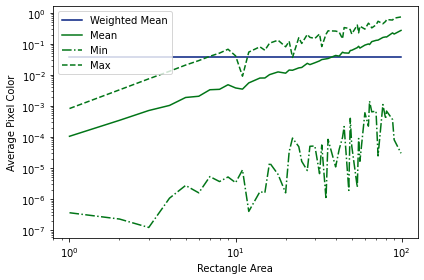

In [12]:
# Visualization of the average pixel color as a function the rectangle area 'A'
fig, ax = fma.newfig(1.0)

rectangle_areas = expectation_values.index.values
mean_all_data = expectation_values_all_data["mean"]["mean"].iloc[0]
ax.plot([rectangle_areas[0], rectangle_areas[-1]], [mean_all_data, mean_all_data], label="Weighted Mean")

ax.plot(rectangle_areas, expectation_values["mean"]["mean"], label="Mean")
ax.plot(rectangle_areas, expectation_values["mean"]["min"], color="C{}".format(1), ls="-.", label="Min")
ax.plot(rectangle_areas, expectation_values["mean"]["max"], color="C{}".format(1), ls="--", label="Max")

ax.legend()
ax.set_xlabel("Rectangle Area")
ax.set_ylabel("Average Pixel Color")
ax.set_xscale("log")
ax.set_yscale("log")
plt.tight_layout()

fma.savefig(directory, "image_mean_over_rectangle_area")

## pystatplottools.distributions - Computation of (Probability) Distributions

### distributions.marginal_distribution - Marginal Distributions / 1D Distributions

In [13]:
from pystatplottools.distributions.marginal_distribution import MarginalDistribution

marginal_distribution = MarginalDistribution(data=data)

range_min, range_max = marginal_distribution.extract_min_max_range_values(["height", "width", "dx", "dy", "mean",
                                                                           "color"])
marginal_distribution.compute(
    axes_indices=["height", "width", "dx", "dy", "mean", "color"],
    range_min=range_min,
    range_max=range_max,
    nbins=[10, 12, 11, 9, 10, 12],
    statistic='probability',
    bin_scales=['linear', 'linear', 'linear', 'linear', 'logarithmic', 'logarithmic']
)

linearized_marginal_distribution = marginal_distribution.linearize(
    order_by_bin=True,
    bin_alignment="center"
)
linearized_marginal_distribution

bin_num_and_dfs       bin         1         2         3         4         5  \
statistics idx                                                                
height     0     1.400000  1.000000  0.502388  0.492016  0.323353  0.503876   
           1     2.200000  0.000000  0.497612  0.000000  0.318031  0.000000   
           2     3.000000  0.000000  0.000000  0.507984  0.000000  0.000000   
           3     3.800000  0.000000  0.000000  0.000000  0.358616  0.000000   
           4     4.600000  0.000000  0.000000  0.000000  0.000000  0.000000   
...                   ...       ...       ...       ...       ...       ...   
color      7     0.008412  0.415354  0.365807  0.306387  0.282768  0.262597   
           8     0.023760  0.169291  0.289398  0.325349  0.343313  0.292636   
           9     0.067110  0.064961  0.099331  0.140719  0.180971  0.197674   
           10    0.189549  0.000000  0.025788  0.041916  0.037924  0.074612   
           11    0.535374  0.000000  0.000000  0.000000  0.006653  0.022287   

bin_num_and_dfs         6         7         8         9  ...        64     66  \
statistics idx                                           ...                    
height     0     0.260458  0.528656  0.243963  0.332054  ...  0.000000  0.000   
           1     0.250996  0.000000  0.262198  0.000000  ...  0.000000  0.000   
           2     0.251494  0.000000  0.000000  0.328215  ...  0.000000  0.000   
           3     0.000000  0.000000  0.248891  0.000000  ...  0.000000  0.000   
           4     0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000   
...                   ...       ...       ...       ...  ...       ...    ...   
color      7     0.215637  0.219368  0.182356  0.160589  ...  0.048096  0.032   
           8     0.370020  0.294466  0.342533  0.358925  ...  0.098196  0.052   
           9     0.220120  0.256917  0.269591  0.266155  ...  0.274549  0.208   
           10    0.066235  0.094862  0.078364  0.102367  ...  0.408818  0.478   
           11    0.008964  0.028656  0.021193  0.031350  ...  0.158317  0.216   

bin_num_and_dfs        70        72        77        80        81        88  \
statistics idx                                                                
height     0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
           1     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
           2     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
           3     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
           4     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...                   ...       ...       ...       ...       ...       ...   
color      7     0.021459  0.019076  0.017857  0.011673  0.028369  0.012170   
           8     0.047210  0.081325  0.071429  0.062257  0.056738  0.040568   
           9     0.231760  0.216867  0.191964  0.173152  0.198582  0.107505   
           10    0.459227  0.443775  0.412946  0.457198  0.462766  0.399594   
           11    0.229614  0.217871  0.292411  0.282101  0.244681  0.430020   

bin_num_and_dfs        90        99  
statistics idx                       
height     0     0.000000  0.000000  
           1     0.000000  0.000000  
           2     0.000000  0.000000  
           3     0.000000  0.000000  
           4     0.000000  0.000000  
...                   ...       ...  
color      7     0.011583  0.016791  
           8     0.067568  0.042910  
           9     0.148649  0.093284  
           10    0.461390  0.386194  
           11    0.301158  0.438433  

[64 rows x 51 columns]

### Visualization as Histograms

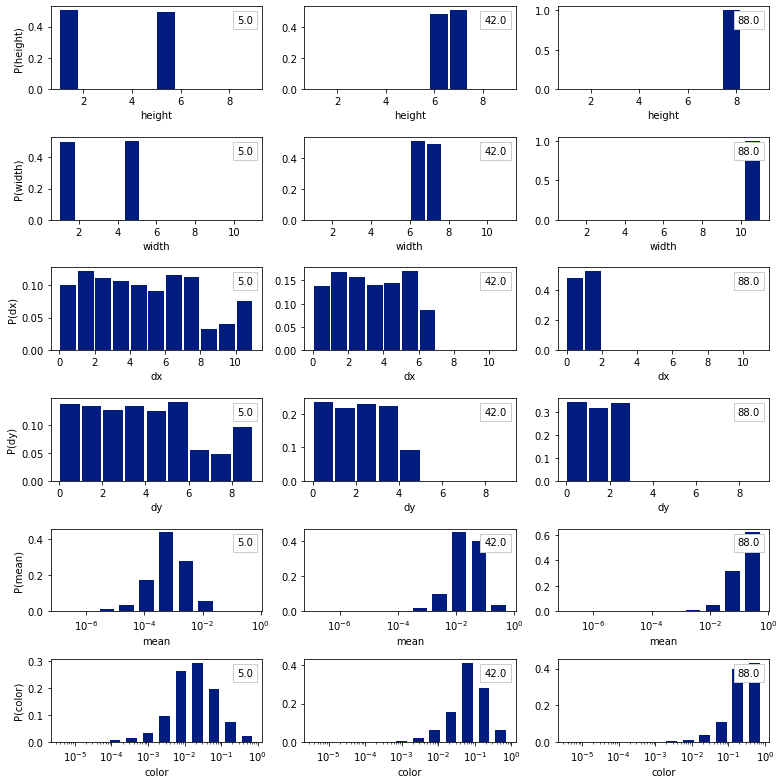

In [14]:
from pystatplottools.utils.bins_and_alignment import revert_align_bins

areas = [5, 42, 88]

fig, axes = fma.newfig(1.8, nrows=6, ncols=3, ratio=1.0, figsize=(11, 11))
for i, area in enumerate(areas):
    for j, (observable, bin_scale) in enumerate(zip(["height", "width", "dx", "dy", "mean", "color"],
                                                    ['linear', 'linear', 'linear', 'linear', 'logarithmic',
                                                     'logarithmic'])):
        binedges = revert_align_bins(
            data_range=linearized_marginal_distribution.loc[observable]["bin"].values,
            bin_alignment="center",
            bin_scale=bin_scale
        )
        if bin_scale == "logarithmic":
            width = 0.6 * (binedges[1:] - binedges[:-1])
            axes[j][i].set_xscale("log")
        else:
            width = 0.9 * (binedges[1:] - binedges[:-1])

        axes[j][i].bar(
            x=linearized_marginal_distribution.loc[observable]["bin"].values,
            height=linearized_marginal_distribution.loc[observable][area].values,
            width=width
        )
        axes[j][i].set_xlabel(observable)
        from pystatplottools.visualization.utils import add_fancy_legend_box
        add_fancy_legend_box(ax=axes[j][i], name=float(area))

for j, observable in enumerate(["height", "width", "dx", "dy", "mean", "color"]):
    axes[j][0].set_ylabel("P(" + observable + ")")
        
# ax.set_xlabel("Rectangle Area")
# ax.set_ylabel("Average Pixel Color")

plt.tight_layout()

fma.savefig(directory, "marginal_distributions")

### distributions.joint_distribution - Joint Distributions

In [15]:
from pystatplottools.distributions.joint_distribution import JointDistribution

joint_distribution = JointDistribution(data=data)

range_min, range_max = joint_distribution.extract_min_max_range_values(["dx", "dy", "mean"])

joint_distribution.compute(
    axes_indices=["dx", "dy", "mean"],
    range_min=range_min,
    range_max=range_max,
    nbins=[11, 9, 10],
    statistic="probability"
)

# Internally a multidimensional histogram is computed with np.histogram() for each rectangle area.
# The histograms can be accessed via: joint_distribution.distribution or linearized.

# Transforms joint_distribution into a linear list of mid boundaries for the different bins
# and the respective statistics for the values
linearized_joint_distribution = joint_distribution.linearize(
    output_statistics_name="prob",
    dataframes_as_columns=False,
    bin_alignment="center"
)
linearized_joint_distribution

axes_and_statistics    dx   dy      mean      prob
dfs idx                                           
1   0                 0.5  0.5  0.036943  0.009843
    1                 0.5  0.5  0.110828  0.000000
    2                 0.5  0.5  0.184714  0.000000
    3                 0.5  0.5  0.258599  0.000000
    4                 0.5  0.5  0.332485  0.000000
...                   ...  ...       ...       ...
99  985              10.5  8.5  0.406370  0.000000
    986              10.5  8.5  0.480255  0.000000
    987              10.5  8.5  0.554141  0.000000
    988              10.5  8.5  0.628026  0.000000
    989              10.5  8.5  0.701912  0.000000

[49500 rows x 4 columns]

### pystatplottools.plotting.contour2D - Visualization of a 2D Joint Distribution

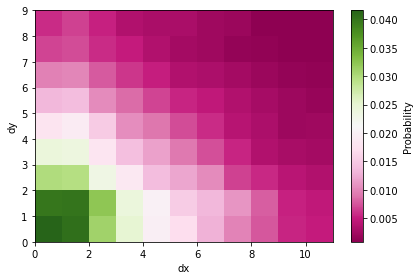

In [16]:
# Preparation - Merge all areas
from pystatplottools.utils.utils import drop_index_level
data_all = drop_index_level(data=data, single_key="df")
from pystatplottools.distributions.joint_distribution import JointDistribution

joint_distribution = JointDistribution(data=data_all)

range_min, range_max = list(map(list, data_all[["dx", "dy"]].agg(["min", "max"]).values))
joint_distribution.compute(
    axes_indices=["dx", "dy"],
    range_min=range_min,
    range_max=range_max,
    nbins=[11, 9],
    statistic='probability'
)

linearized_joint_distribution = joint_distribution.linearize(output_statistics_name="prob")

# Contour plot
fig, ax = fma.newfig(1.4)

from pystatplottools.plotting.contour2D import Contour2D

contour2D = Contour2D(
    ax=ax,
    data=linearized_joint_distribution.loc["df"],
    x="dx",  # possibility to rescale x and y axis or perform other operation for x axis
    # like computing a mass difference
    y="dy",
    z_index="prob"
)

contour2D.set_ax_labels(x_label="dx", y_label="dy")
cf = contour2D.pcolormesh(
    cbar_scale="Lin",
    lev_num=40,
    cmap="PiYG"
)
contour2D.add_colorbar(fig=fig, cf=cf, z_label="Probability")

plt.tight_layout()
fma.savefig(directory, "probability_colormesh")

### distributions.binned_statistics - Computation of Binned Statistics

Computing and Visualizing mean for different values of (dx, height)

In [17]:
# Preparation - Merge all areas
from pystatplottools.utils.utils import drop_index_level
data_all = drop_index_level(data=data, single_key="df")

from pystatplottools.distributions.binned_statistics import BinnedStatistics

binned_statistics = BinnedStatistics(data=data_all)

range_min, range_max = list(map(list, data_all[["dx", "height"]].agg(["min", "max"]).values))
binned_statistics.compute(
    axes_indices=["dx", "height"],
    columns=["mean", "color"],
    range_min=range_min,
    range_max=range_max,
    nbins=[11, 8],
    statistic='mean'
)

linearized_statistics = binned_statistics.linearize(
    output_statistics_names=["mean", "color"],
    dataframes_as_columns=False,
    bin_alignment="center"
)
linearized_statistics

axes_and_statistics    dx  height      mean     color
dfs idx                                              
df  0                 0.5     1.5  0.003245  0.050788
    1                 0.5     2.5  0.013531  0.104215
    2                 0.5     3.5  0.029392  0.153078
    3                 0.5     4.5  0.050368  0.197386
    4                 0.5     5.5  0.079402  0.248936
...                   ...     ...       ...       ...
    83               10.5     4.5  0.000822  0.017776
    84               10.5     5.5  0.001298  0.022041
    85               10.5     6.5  0.001919  0.028166
    86               10.5     7.5  0.002650  0.032157
    87               10.5     8.5  0.003424  0.035719

[88 rows x 4 columns]

### Visualization of Binned Statistics with a Logarithmic Colorbar

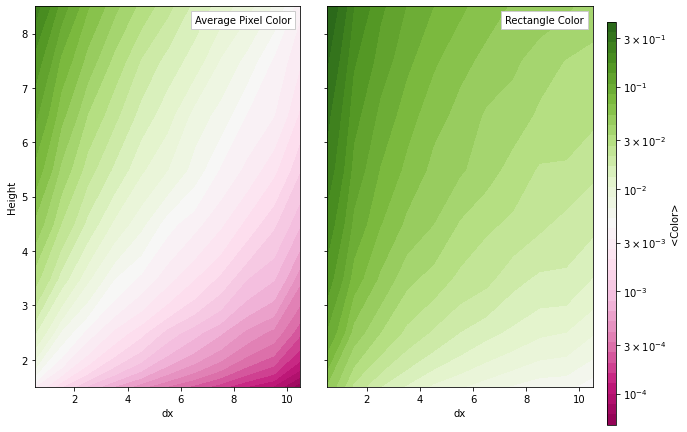

In [18]:
# Contour plot
fig, ax = fma.newfig(1.4, figsize=(10, 7), ratio=0.5, nrows=1, ncols=2)

# Preparation
from pystatplottools.plotting.contour2D import Contour2D

contour2D_mean = Contour2D(
    ax=ax[0],
    data=linearized_statistics.loc["df"],
    x="dx",
    y="height",
    z_index="mean"
)

contour2D_color = Contour2D(
    ax=ax[1],
    data=linearized_statistics.loc["df"],
    x="dx",
    y="height",
    z_index="color"
)

contour2D_mean.set_ax_labels(x_label="dx", y_label="Height")

contour2D_color.set_ax_labels(x_label="dx")
contour2D_color.set_ax_label_visibility(ax[1], y_ticks_visible=False)

lev_min = linearized_statistics[["mean", "color"]].values.min()
lev_max = linearized_statistics[["mean", "color"]].values.max()
norm, levs = Contour2D.get_log_norm_and_levs(lev_min=lev_min, lev_max=lev_max, lev_num=40)

contour2D_mean.contourf(
    norm=norm,
    levs=levs,
    cmap="PiYG"
)
contour2D_mean.add_fancy_box("Average Pixel Color")

cf = contour2D_color.contourf(
    norm=norm,
    levs=levs,
    cmap="PiYG"
)
contour2D_color.add_fancy_box("Rectangle Color")

fig.subplots_adjust(wspace=0.1, right=0.9)
cbar_ax = fig.add_axes([0.92, 0.05, 0.012, 0.8])

Contour2D.add_colorbar(
    fig=fig, cf=cf,
    z_label="<Color>",
    cax=cbar_ax,
    z_ticks=[1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1],
    z_tick_labels=['$10^{-4}$', '$3\\times10^{-4}$', '$10^{-3}$', '$3\\times10^{-3}$', '$10^{-2}$',
                   '$3\\times10^{-2}$', '$10^{-1}$', '$3\\times10^{-1}$']
)

fma.savefig(directory, "mean_colormesh")

### distributions.sparse_joint_distribution - Computation of Joint Distributions in High Dimensions and Marginalization

Preparation

In [19]:
# Downsizing dataset samples - Mean value over 2x2 blocks (from 10 x 12 to 5 x 6)
sample_data = data_loader.dataset.data.cpu().numpy().reshape(len(data_loader.dataset), -1)
sample_data = sample_data.reshape(-1, 5, 2, 6, 2).mean(axis=(2, 4)).reshape(len(data_loader.dataset), -1)
import pandas as pd
from pystatplottools.utils.utils import add_index_level
sample_data = add_index_level(data=pd.DataFrame(sample_data), key="df")
sample_data # 30 pixels per sample

0         1         2         3         4         5         6   \
df 0      0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
   1      0.0  0.000000  0.006418  0.012837  0.012837  0.000000  0.000000   
   2      0.0  0.003790  0.007580  0.007580  0.003790  0.000000  0.000000   
   3      0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
   4      0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...       ...       ...       ...       ...       ...       ...       ...   
   39995  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
   39996  0.0  0.037411  0.074823  0.074823  0.074823  0.037411  0.000000   
   39997  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
   39998  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
   39999  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.229928   

                7         8         9   ...        20        21        22  \
df 0      0.036702  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
   1      0.000000  0.012837  0.025674  ...  0.000000  0.000000  0.000000   
   2      0.003790  0.007580  0.007580  ...  0.000000  0.000000  0.000000   
   3      0.000000  0.000000  0.060889  ...  0.000000  0.030445  0.030445   
   4      0.000000  0.000000  0.000000  ...  0.028251  0.028251  0.000000   
...            ...       ...       ...  ...       ...       ...       ...   
   39995  0.000000  0.000000  0.000000  ...  0.081284  0.081284  0.081284   
   39996  0.074823  0.149645  0.149645  ...  0.149645  0.149645  0.149645   
   39997  0.000000  0.000000  0.000000  ...  0.182876  0.182876  0.182876   
   39998  0.017675  0.017675  0.000000  ...  0.035351  0.000000  0.000000   
   39999  0.229928  0.229928  0.229928  ...  0.229928  0.229928  0.229928   

                23        24        25        26        27        28        29  
df 0      0.000000  0.000000  0.073404  0.000000  0.000000  0.000000  0.000000  
   1      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
   2      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
   3      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
   4      0.000000  0.000000  0.000000  0.014125  0.014125  0.000000  0.000000  
...            ...       ...       ...       ...       ...       ...       ...  
   39995  0.040642  0.040642  0.040642  0.040642  0.040642  0.040642  0.020321  
   39996  0.074823  0.000000  0.074823  0.149645  0.149645  0.149645  0.074823  
   39997  0.091438  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
   39998  0.000000  0.000000  0.035351  0.035351  0.000000  0.000000  0.000000  
   39999  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  

[40000 rows x 30 columns]

### Computation of a Sparse Joint Distribution in Pixel Space with 10 Bins in each Dimension'.

In [20]:
from pystatplottools.distributions.sparse_joint_distribution import SparseJointDistribution

spare_joint_distribution = SparseJointDistribution(data=sample_data)
range_min, range_max = spare_joint_distribution.extract_min_max_range_values()

spare_joint_distribution.compute(
    statistic="probability",
    transform='lin',
    nbins=[10 for _ in range(len(sample_data.columns))],
    range_min=range_min,
    range_max=range_max,
    bin_scales='linear',
    one_dim_bin_index=False
)

sparse_distribution = spare_joint_distribution.distribution

linearized_sparse_distribution, bin_information = spare_joint_distribution.linearize(order_by_bin=True)

# Data is stored by a vector (bin_0, ..., bin_29) consisting of the bin index in each dimension
linearized_sparse_distribution

bin_num_and_dfs   bin_0  bin_1  bin_2  bin_3  bin_4  bin_5  bin_6  bin_7  \
statistics  idx                                                            
probability 0         0      0      0      0      0      0      0      0   
            1         0      0      0      0      0      0      0      0   
            2         0      0      0      0      0      0      0      0   
            3         0      0      0      0      0      0      0      0   
            4         0      0      0      0      0      0      0      0   
...                 ...    ...    ...    ...    ...    ...    ...    ...   
            2262      9      9      9      9      0      0      8      8   
            2263      9      9      9      9      0      0      9      9   
            2264      9      9      9      9      4      0      9      9   
            2265      9      9      9      9      9      0      9      9   
            2266      9      9      9      9      9      9      9      9   

bin_num_and_dfs   bin_8  bin_9  ...  bin_21  bin_22  bin_23  bin_24  bin_25  \
statistics  idx                 ...                                           
probability 0         0      0  ...       0       0       0       0       0   
            1         0      0  ...       0       0       0       0       0   
            2         0      0  ...       0       0       0       0       1   
            3         0      0  ...       0       0       0       0       1   
            4         0      0  ...       0       0       0       0       1   
...                 ...    ...  ...     ...     ...     ...     ...     ...   
            2262      8      8  ...       8       0       0       4       4   
            2263      9      9  ...       9       0       0       4       4   
            2264      9      9  ...       9       4       0       4       4   
            2265      9      9  ...       9       9       0       4       4   
            2266      9      9  ...       9       9       9       4       4   

bin_num_and_dfs   bin_26  bin_27  bin_28  bin_29        df  
statistics  idx                                             
probability 0          0       0       0       0  0.625175  
            1          0       0       0       1  0.001000  
            2          0       0       0       0  0.000150  
            3          1       0       0       0  0.000200  
            4          1       1       0       0  0.000275  
...                  ...     ...     ...     ...       ...  
            2262       4       4       0       0  0.000025  
            2263       4       4       0       0  0.000175  
            2264       4       4       2       0  0.000125  
            2265       4       4       4       0  0.000250  
            2266       4       4       4       4  0.000275  

[2267 rows x 31 columns]

Possiblity to represent this as a joint distribution with respective bins

In [21]:
linearized_joint_distribution = spare_joint_distribution.linearized_sparse_distribution_to_linearized_joint_distribution(
    linearized_sparse_distribution=linearized_sparse_distribution,
    bin_information=bin_information,
    bin_alignment="center"
)
linearized_joint_distribution

axes_and_dfs             0         1         2         3         4         5  \
statistics  idx                                                                
probability 0     0.044870  0.044870  0.044870  0.044788  0.044788  0.022406   
            1     0.044870  0.044870  0.044870  0.044788  0.044788  0.022406   
            2     0.044870  0.044870  0.044870  0.044788  0.044788  0.022406   
            3     0.044870  0.044870  0.044870  0.044788  0.044788  0.022406   
            4     0.044870  0.044870  0.044870  0.044788  0.044788  0.022406   
...                    ...       ...       ...       ...       ...       ...   
            2262  0.852528  0.852528  0.852528  0.850978  0.044788  0.022406   
            2263  0.852528  0.852528  0.852528  0.850978  0.044788  0.022406   
            2264  0.852528  0.852528  0.852528  0.850978  0.403095  0.022406   
            2265  0.852528  0.852528  0.852528  0.850978  0.850978  0.022406   
            2266  0.852528  0.852528  0.852528  0.850978  0.850978  0.425709   

axes_and_dfs             6         7         8         9  ...        21  \
statistics  idx                                           ...             
probability 0     0.044988  0.044988  0.044988  0.044988  ...  0.044988   
            1     0.044988  0.044988  0.044988  0.044988  ...  0.044988   
            2     0.044988  0.044988  0.044988  0.044988  ...  0.044988   
            3     0.044988  0.044988  0.044988  0.044988  ...  0.044988   
            4     0.044988  0.044988  0.044988  0.044988  ...  0.044988   
...                    ...       ...       ...       ...  ...       ...   
            2262  0.764793  0.764793  0.764793  0.764793  ...  0.764793   
            2263  0.854768  0.854768  0.854768  0.854768  ...  0.854768   
            2264  0.854768  0.854768  0.854768  0.854768  ...  0.854768   
            2265  0.854768  0.854768  0.854768  0.854768  ...  0.854768   
            2266  0.854768  0.854768  0.854768  0.854768  ...  0.854768   

axes_and_dfs            22        23        24        25        26        27  \
statistics  idx                                                                
probability 0     0.044936  0.022451  0.044988  0.044988  0.044988  0.044988   
            1     0.044936  0.022451  0.044988  0.044988  0.044988  0.044988   
            2     0.044936  0.022451  0.044988  0.134963  0.044988  0.044988   
            3     0.044936  0.022451  0.044988  0.134963  0.134963  0.044988   
            4     0.044936  0.022451  0.044988  0.134963  0.134963  0.134963   
...                    ...       ...       ...       ...       ...       ...   
            2262  0.044936  0.022451  0.404890  0.404890  0.404890  0.404890   
            2263  0.044936  0.022451  0.404890  0.404890  0.404890  0.404890   
            2264  0.404421  0.022451  0.404890  0.404890  0.404890  0.404890   
            2265  0.853778  0.022451  0.404890  0.404890  0.404890  0.404890   
            2266  0.853778  0.426572  0.404890  0.404890  0.404890  0.404890   

axes_and_dfs            28        29        df  
statistics  idx                                 
probability 0     0.044936  0.022451  0.625175  
            1     0.044936  0.067353  0.001000  
            2     0.044936  0.022451  0.000150  
            3     0.044936  0.022451  0.000200  
            4     0.044936  0.022451  0.000275  
...                    ...       ...       ...  
            2262  0.044936  0.022451  0.000025  
            2263  0.044936  0.022451  0.000175  
            2264  0.224678  0.022451  0.000125  
            2265  0.404421  0.022451  0.000250  
            2266  0.404421  0.202060  0.000275  

[2267 rows x 31 columns]

### Marginalization - Also works for distributions.joint_distribution

In [22]:
partly_marginalized_distribution = spare_joint_distribution.marginalize(
    initial_axes_indices=list(range(30)), remaining_axes_indices=list(range(5)), data=linearized_joint_distribution)

partly_marginalized_distribution

axes_and_dfs            0         1         2         3         4        df
statistics  idx                                                            
probability 0    0.044870  0.044870  0.044870  0.044788  0.044788  0.861525
            1    0.044870  0.044870  0.044870  0.044788  0.134365  0.000525
            2    0.044870  0.044870  0.044870  0.134365  0.044788  0.001225
            3    0.044870  0.044870  0.044870  0.134365  0.134365  0.002975
            4    0.044870  0.044870  0.134610  0.044788  0.044788  0.003000
...                   ...       ...       ...       ...       ...       ...
            134  0.852528  0.852528  0.852528  0.044788  0.044788  0.000125
            135  0.852528  0.852528  0.852528  0.403095  0.044788  0.000050
            136  0.852528  0.852528  0.852528  0.850978  0.044788  0.000200
            137  0.852528  0.852528  0.852528  0.850978  0.403095  0.000125
            138  0.852528  0.852528  0.852528  0.850978  0.850978  0.000525

[139 rows x 6 columns]

### Verify if the computed marginal distribution is correct

In [23]:
# Verify marginal distribution

part_spare_joint_distribution = SparseJointDistribution(data=sample_data[list(range(5))])
part_range_min, part_range_max = part_spare_joint_distribution.extract_min_max_range_values()

part_sparse_distribution = part_spare_joint_distribution.compute(
    statistic="probability",
    transform='lin',
    nbins=[10 for _ in range(5)],
    range_min=part_range_min,
    range_max=part_range_max,
    bin_scales='linear'
)

linearized_part_sparse_distribution, part_bin_information = part_spare_joint_distribution.linearize(order_by_bin=True)

linearized_part_joint_distribution = part_spare_joint_distribution.linearized_sparse_distribution_to_linearized_joint_distribution(
    linearized_sparse_distribution=linearized_part_sparse_distribution,
    bin_information=part_bin_information,
    bin_alignment="center"
)

# assert np.sum(partly_marginalized_distribution.values - linearized_part_joint_distribution.values) < 1e-10, \
#     "Distributions do not coincide"

linearized_part_joint_distribution

axes_and_dfs            0         1         2         3         4        df
statistics  idx                                                            
probability 0    0.044870  0.044870  0.044870  0.044788  0.044788  0.861525
            1    0.044870  0.044870  0.044870  0.044788  0.134365  0.000525
            2    0.044870  0.044870  0.044870  0.134365  0.044788  0.001225
            3    0.044870  0.044870  0.044870  0.134365  0.134365  0.002975
            4    0.044870  0.044870  0.134610  0.044788  0.044788  0.003000
...                   ...       ...       ...       ...       ...       ...
            134  0.852528  0.852528  0.852528  0.044788  0.044788  0.000125
            135  0.852528  0.852528  0.852528  0.403095  0.044788  0.000050
            136  0.852528  0.852528  0.852528  0.850978  0.044788  0.000200
            137  0.852528  0.852528  0.852528  0.850978  0.403095  0.000125
            138  0.852528  0.852528  0.852528  0.850978  0.850978  0.000525

[139 rows x 6 columns]

In [24]:
# Check whether partly_marginalized_distribution and linearized_part_joint_distribution are the same
np.sum(partly_marginalized_distribution.values - linearized_part_joint_distribution.values)

-2.168404344971009e-19